## Imports

In [87]:
import numpy as np
import numpy as numpy
import pandas as pd
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import  preprocessing
from sklearn.model_selection import train_test_split ## Cross- validation
from scipy.spatial import distance

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc,roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from prettytable import PrettyTable

from scipy.spatial import distance

# Utils


# Data Preprocessing

## Reading the dataset

In [88]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## Transform data

In [89]:
from sklearn.preprocessing import LabelEncoder
lbenc=LabelEncoder()
df['Month']= lbenc.fit_transform(df['Month'])
df['VisitorType']= lbenc.fit_transform(df['VisitorType'])

X = df.loc[:,df.columns!='Revenue'] #Independent Variables
Y = df.loc[:,'Revenue'] #Dependent Variable

## Normalization

Para la normalizacion se usara StandardScalar de tal modo que su distribucion tenga un valor medio de 0 y una desviacion estandar de 1.

z = (x - u) /s

In [90]:
X = (X - X.mean()) / (X.std())


## Balanced

Dado que la base de datos se encuentra desbalanceada, se considera el uso de submuestreo y sobremuestreo inteligente, ademas de una validacion estratificada

### Validacion boostraping

In [91]:
VALID_SIZE = 0.30

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=VALID_SIZE, shuffle=True )
print('X_Train', X_train.shape)
print('y_train', y_train.shape)

X_Train (8631, 17)
y_train (8631,)


### SMOTE




In [92]:
sm = SMOTE( ratio = 0.5)

XS_train, ys_train = sm.fit_sample(X_train, y_train)
XS_test, ys_test = X_test, y_test

print('X_Train' + str(X_train.shape) + '--> XS_train ' +  str(XS_train.shape))
print('y_train'+ str(y_train.shape) + '-->  ys_train ' +  str(ys_train.shape))

print("Muestras por clase ")

print('Clase 0 ' + str(len(ys_train[(ys_train == 0)])))
print('Clase 1 ' + str(len(ys_train[(ys_train  == 1)])))

X_Train(8631, 17)--> XS_train (10956, 17)
y_train(8631,)-->  ys_train (10956,)
Muestras por clase 
Clase 0 7304
Clase 1 3652


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [93]:
def metrics(model, X_test ,Y_test, Y_pred):
    #Accuracy
    acurracy = accuracy_score(y_true = Y_test, y_pred = Y_pred)
    print("Acurracy : " + str(acurracy))
    #FScore
    f1 = f1_score(y_true = Y_test, y_pred = Y_pred)
    print("F1_Score : " + str(f1))
    #Reporte de clasificacion
    report = classification_report(Y_test, Y_pred)
    print("\nclassification report :\n",report )
    # Matriz de confusión
    plt.figure(figsize=(13,10))
    plt.subplot(221)
    matrix = confusion_matrix(Y_test, Y_pred,normalize='true')
    sns.heatmap(matrix,annot=True,linecolor="black",linewidths=3, cmap="Blues")
    plt.title("Matriz de confusión",fontsize=20)
    
    #Sensibilidad y especificidad
    sensitivity = matrix[0,0]/(matrix[0,0]+matrix[0,1])
    print('Sensibilidad : ', sensitivity )
    specificity = matrix[1,1]/(matrix[1,0]+matrix[1,1])
    print('Especificidad : ', specificity)
    precition = matrix[0,0]/(matrix[0,0]+matrix[1,0])
    print('Precision : ', precition)
    eficiency = (matrix[1,1] + matrix[0,0])/(matrix[1,1]+matrix[0,0]+matrix[1,0]+matrix[0,1])
    print('Eficiencia : ', eficiency)
    
    
    # Curva ROC
    #predicting_probabilites = model.predict_proba(X_test)[:,1]
    predicting_probabilites = Y_pred
    fpr,tpr,thresholds = roc_curve(Y_test, predicting_probabilites)
    plt.subplot(222)
    plt.plot(fpr,tpr,label = ("Área bajo la curva:",roc_auc_score(Y_test,predicting_probabilites)),color = "r")
    plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
    plt.legend(loc = "best")
    plt.title("\nCurva ROC",fontsize=20)   

    # Curva Precision-Recall 
    precision,recall,thresholds = precision_recall_curve(Y_test, predicting_probabilites)
    c_auc = auc(recall, precision)

    plt.subplot(223)
    plt.plot(recall,precision,label = ("Área bajo la curva:",c_auc),color = "r")
    plt.plot([0,1],[0.5,0.5],linestyle = "dashed",color ="k")
    plt.legend(loc = "best")
    plt.title("\nCurva Precision-Recall",fontsize=20)   

In [94]:
class ParzenWindowClassifier:
  def __init__(self, h):
        #self.kernel = lambda x, sigma : np.exp(-.5 * x.dot(x.T)[0,0] / sigma ** 2) / (np.sqrt(2 * np.pi * sigma **2))
        self.kernel = lambda x: np.exp((-0.5)*x**2)
        self.h = h

  def parzenWindow(self, x, Data):
        h = self.h
        Ns = Data.shape[0]
        suma = 0
        for k in range(Ns):
            u = distance.euclidean(x,Data[:,k])
            suma += self.kernel(u/h)
        return suma

  def fit(self, X, y):
        self.X = X
        self.y = y
        self.clases = np.unique(y)


  def predict2(self, x):
        Yest = np.zeros(self.X.shape[0])
        x = x.values
        k = []
        fds_matrix = np.zeros((x.shape[0], numpy.size(self.clases)))
        for n, sample in enumerate(x):
            Y_aux = np.zeros(len(self.clases))
            for i, clase in enumerate(self.clases):
                indices_entre = np.where(self.y == clase)
                N = len(indices_entre)
                entrenamiento = np.take(self.X, indices_entre)
                Y_aux[i] = self.parzenWindow(sample, entrenamiento)/(N)
            min = numpy.amax((Y_aux))
            Yest[n] = numpy.where(Y_aux == min)[0][0]
            fds_matrix[n] = Y_aux
            k.append(Yest[n])
        return np.array(k), fds_matrix

  def predict(self, x):
        h = self.h
        Nv = len(x)
        Y_est = np.array([])
        X_clases = []
        for clase in np.unique(self.y):
            X_clases.append(self.X[np.where(self.y == clase )])   
        probabilidades = []
        j = 0
        for x_clase in X_clases:     
          distances = sp.spatial.distance_matrix(x, x_clase) / h
          for i in range(Nv):
                k = self.kernel(distances[i])
                P = np.sum(k)
                if(j == 0):
                    probabilidades.append([P, 0.0, 0.0])
                else:
                    probabilidades[i][j] = P
          j += 1   
        for p in probabilidades:
            Y_est = np.append(Y_est,p.index(max(p)))
        return Y_est    
      
     

# Modelo - Ventana de parzen

Evaluamos el modelo con SMOTE

In [95]:
hs = [0.1, 0.3, 0.5,0.6, 0.7, 0.8, 0.9, 1]

table = PrettyTable(['h', 'Accuracy', 'f1_score', 'auc'])

h_selected = 0
old_auc = 0
preds_selected = 0
for h in hs:
  model = ParzenWindowClassifier(h)
  model.fit(XS_train, ys_train)
  preds = model.predict(XS_test)
  precision,recall,thresholds = precision_recall_curve(ys_test, preds)
  c_auc = auc(recall, precision )
  if(c_auc > old_auc):
        preds_selected = preds
        h_selected = h
        old_auc = c_auc
  table.add_row([h, accuracy_score(ys_test, preds), f1_score(y_true = ys_test, y_pred = preds),c_auc])
print(table)

print("Model selected with h " + str(h_selected) )



+-----+--------------------+--------------------+--------------------+
|  h  |      Accuracy      |      f1_score      |        auc         |
+-----+--------------------+--------------------+--------------------+
| 0.1 | 0.8364422816977561 | 0.5036915504511895 | 0.5418323040882244 |
| 0.3 | 0.8383346850500135 | 0.5122349102773246 | 0.5497254402255496 |
| 0.5 | 0.8518518518518519 | 0.5387205387205386 | 0.574258501970287  |
| 0.6 | 0.8545552852122196 | 0.5370051635111877 | 0.5733663422081328 |
| 0.7 | 0.8602324952689916 | 0.5428824049513704 | 0.5803276018938669 |
| 0.8 | 0.8656393619897269 | 0.5502262443438913 | 0.5891367880910718 |
| 0.9 | 0.8661800486618005 | 0.5360824742268042 | 0.5802416918022895 |
|  1  | 0.8672614220059476 | 0.5265188042430088 | 0.5759147380489645 |
+-----+--------------------+--------------------+--------------------+
Model selected with h 0.8


Acurracy : 0.8656393619897269
F1_Score : 0.5502262443438913

classification report :
               precision    recall  f1-score   support

       False       0.91      0.93      0.92      3118
        True       0.58      0.52      0.55       581

    accuracy                           0.87      3699
   macro avg       0.75      0.73      0.74      3699
weighted avg       0.86      0.87      0.86      3699

Sensibilidad :  0.9294419499679282
Especificidad :  0.5232358003442341
Precision :  0.6609571080432625
Eficiencia :  0.7263388751560811


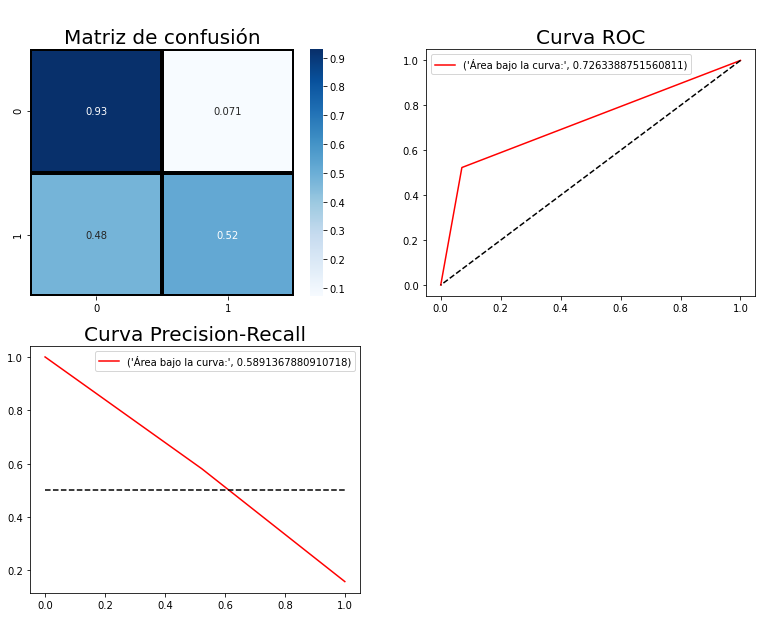

In [96]:
metrics(model, XS_test, ys_test, preds_selected)